# Smart San Antonio

In [1]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('talk')
plt.style.use('tableau-colorblind10')

## Acquire

In [2]:
df_brooks = pd.read_csv('./data/brooks.csv')
df_downtown = pd.read_csv('./data/downtown.csv')
df_medical = pd.read_csv('./data/medical.csv')

## Brooks Sound Senors

In [3]:
df_brooks.head()

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
0,2021-05-20T00:01:27,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal
1,2021-05-20T00:04:27,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal
2,2021-05-20T00:07:28,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal
3,2021-05-20T00:10:27,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal
4,2021-05-20T00:13:27,689324d0f345350d,ATT,AQM-01-00-01-00-01-00-GY,29.34473,-98.435672,Brooks,59,None,Normal


In [4]:
df_brooks.tail()

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
38920,2021-05-29T23:35:00,63554,ITRON,noise,29.34159,-98.43956,Brooks,50,NaN,Normal
38921,2021-05-29T23:40:00,63554,ITRON,noise,29.34159,-98.43956,Brooks,49,NaN,Normal
38922,2021-05-29T23:45:00,63554,ITRON,noise,29.34159,-98.43956,Brooks,48,NaN,Normal
38923,2021-05-29T23:50:00,63554,ITRON,noise,29.34159,-98.43956,Brooks,47,NaN,Normal
38924,2021-05-29T23:55:00,63554,ITRON,noise,29.34159,-98.43956,Brooks,48,NaN,Normal


In [5]:
df_brooks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38925 entries, 0 to 38924
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DateTime        38925 non-null  object 
 1   Sensor_id       38925 non-null  object 
 2   Vendor          38925 non-null  object 
 3   SensorModel     38925 non-null  object 
 4   LAT             38925 non-null  float64
 5   LONG            38925 non-null  float64
 6   Zone            38925 non-null  object 
 7   NoiseLevel_db   38925 non-null  int64  
 8   AlertTriggered  30573 non-null  object 
 9   SensorStatus    38925 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.0+ MB


In [6]:
df_brooks.isna().sum()

DateTime             0
Sensor_id            0
Vendor               0
SensorModel          0
LAT                  0
LONG                 0
Zone                 0
NoiseLevel_db        0
AlertTriggered    8352
SensorStatus         0
dtype: int64

In [7]:
df_brooks.nunique()

DateTime          24844
Sensor_id             4
Vendor                2
SensorModel           2
LAT                   4
LONG                  4
Zone                  1
NoiseLevel_db        53
AlertTriggered        1
SensorStatus          1
dtype: int64

In [8]:
df_brooks.describe()

,LAT,LONG,NoiseLevel_db
count,38925.000000,38925.000000,38925.000000
mean,29.344140,-98.436412,59.755453
std,0.001446,0.001784,8.499940
min,29.341590,-98.439560,30.000000
25%,29.344120,-98.436440,54.000000
50%,29.344730,-98.435672,58.000000
75%,29.345660,-98.434544,65.000000
max,29.345660,-98.434544,194.000000


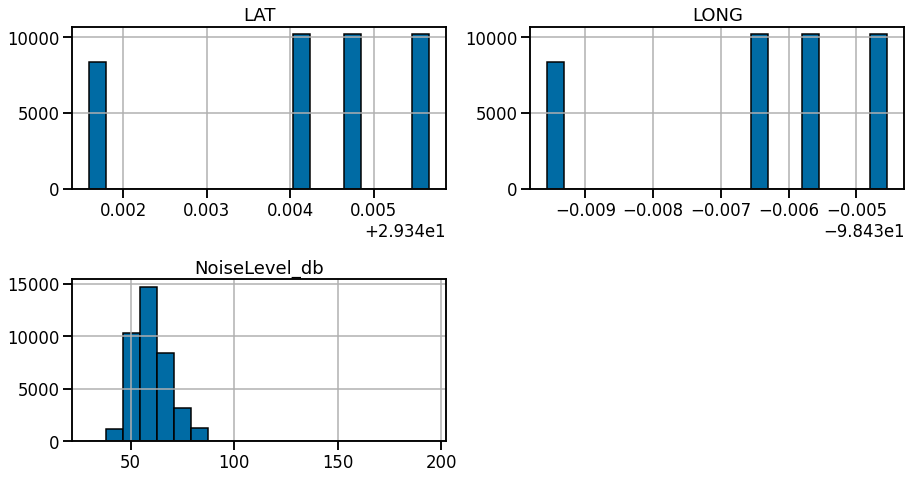

In [9]:
df_brooks.hist(figsize=(13, 7), bins=20, ec='black')
plt.tight_layout();

## Downtown Sound Sensors

In [10]:
df_downtown.head()

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
0,2021-05-20T00:01:27,64d7e4dbde37ccb5,ATT,AQM-01-00-01-00-01-00-GY,29.4159,-98.482952,Downtown,55,None,Normal
1,2021-05-20T00:04:28,64d7e4dbde37ccb5,ATT,AQM-01-00-01-00-01-00-GY,29.4159,-98.482952,Downtown,55,None,Normal
2,2021-05-20T00:07:27,64d7e4dbde37ccb5,ATT,AQM-01-00-01-00-01-00-GY,29.4159,-98.482952,Downtown,55,None,Normal
3,2021-05-20T00:10:27,64d7e4dbde37ccb5,ATT,AQM-01-00-01-00-01-00-GY,29.4159,-98.482952,Downtown,55,None,Normal
4,2021-05-20T00:13:27,64d7e4dbde37ccb5,ATT,AQM-01-00-01-00-01-00-GY,29.4159,-98.482952,Downtown,55,None,Normal


In [11]:
df_downtown.tail()

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
47275,2021-05-29T23:45:00,63540,ITRON,noise,29.42288,-98.48693,Downtown,68,NaN,Normal
47276,2021-05-29T23:50:00,63547,ITRON,noise,29.42210,-98.48366,Downtown,65,NaN,Normal
47277,2021-05-29T23:50:00,63540,ITRON,noise,29.42288,-98.48693,Downtown,66,NaN,Normal
47278,2021-05-29T23:55:00,63547,ITRON,noise,29.42210,-98.48366,Downtown,65,NaN,Normal
47279,2021-05-29T23:55:00,63540,ITRON,noise,29.42288,-98.48693,Downtown,67,NaN,Normal


In [12]:
df_downtown.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47280 entries, 0 to 47279
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DateTime        47280 non-null  object 
 1   Sensor_id       47280 non-null  object 
 2   Vendor          47280 non-null  object 
 3   SensorModel     47280 non-null  object 
 4   LAT             47280 non-null  float64
 5   LONG            47280 non-null  float64
 6   Zone            47280 non-null  object 
 7   NoiseLevel_db   47280 non-null  int64  
 8   AlertTriggered  30576 non-null  object 
 9   SensorStatus    47280 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.6+ MB


In [13]:
df_downtown.nunique()

DateTime          24838
Sensor_id             5
Vendor                2
SensorModel           2
LAT                  11
LONG                 11
Zone                  3
NoiseLevel_db        47
AlertTriggered        1
SensorStatus          1
dtype: int64

In [14]:
df_downtown.isna().sum()

DateTime              0
Sensor_id             0
Vendor                0
SensorModel           0
LAT                   0
LONG                  0
Zone                  0
NoiseLevel_db         0
AlertTriggered    16704
SensorStatus          0
dtype: int64

In [15]:
df_downtown.describe()

,LAT,LONG,NoiseLevel_db
count,47280.000000,47280.000000,47280.000000
mean,29.418173,-98.483706,58.562923
std,0.003247,0.001749,15.710386
min,29.414860,-98.486930,30.000000
25%,29.415900,-98.484080,57.000000
50%,29.416610,-98.483660,65.000000
75%,29.422100,-98.482880,69.000000
max,29.422880,-98.481432,191.000000


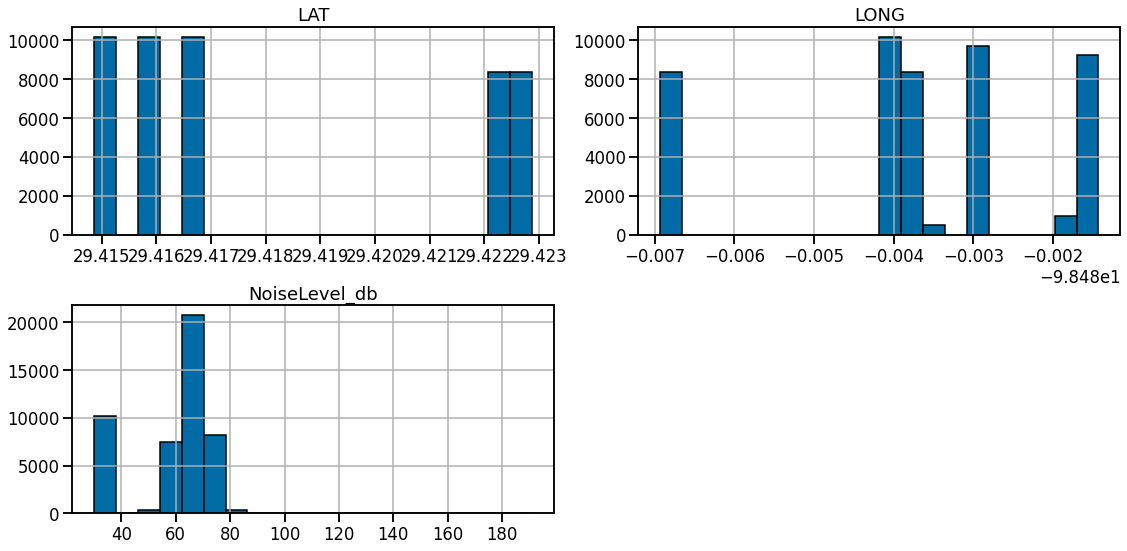

In [16]:
df_downtown.hist(figsize=(16, 8), bins=20, ec='black')
plt.tight_layout()

## Medical Sound Sensors

In [17]:
df_medical.head()

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
0,2021-05-20T00:01:27,63e0b0eae3495a39,ATT,AQM-01-00-01-00-01-00-GY,29.51007,-98.580288,Medical Center,61,None,Normal
1,2021-05-20T00:04:28,63e0b0eae3495a39,ATT,AQM-01-00-01-00-01-00-GY,29.51007,-98.580288,Medical Center,61,None,Normal
2,2021-05-20T00:07:27,63e0b0eae3495a39,ATT,AQM-01-00-01-00-01-00-GY,29.51007,-98.580288,Medical Center,61,None,Normal
3,2021-05-20T00:10:27,63e0b0eae3495a39,ATT,AQM-01-00-01-00-01-00-GY,29.51007,-98.580288,Medical Center,61,None,Normal
4,2021-05-20T00:13:27,63e0b0eae3495a39,ATT,AQM-01-00-01-00-01-00-GY,29.51007,-98.580288,Medical Center,61,None,Normal


In [18]:
df_medical.tail()

,DateTime,Sensor_id,Vendor,SensorModel,LAT,LONG,Zone,NoiseLevel_db,AlertTriggered,SensorStatus
38923,2021-05-29T23:35:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,59,NaN,Normal
38924,2021-05-29T23:40:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,60,NaN,Normal
38925,2021-05-29T23:45:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,60,NaN,Normal
38926,2021-05-29T23:50:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,60,NaN,Normal
38927,2021-05-29T23:55:00,63568,ITRON,noise,29.5093,-98.58361,Medical Center,60,NaN,Normal


In [19]:
df_medical.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38928 entries, 0 to 38927
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   DateTime        38928 non-null  object 
 1   Sensor_id       38928 non-null  object 
 2   Vendor          38928 non-null  object 
 3   SensorModel     38928 non-null  object 
 4   LAT             38928 non-null  float64
 5   LONG            38928 non-null  float64
 6   Zone            38928 non-null  object 
 7   NoiseLevel_db   38928 non-null  int64  
 8   AlertTriggered  30576 non-null  object 
 9   SensorStatus    38928 non-null  object 
dtypes: float64(2), int64(1), object(7)
memory usage: 3.0+ MB


In [20]:
df_medical.isna().sum()

DateTime             0
Sensor_id            0
Vendor               0
SensorModel          0
LAT                  0
LONG                 0
Zone                 0
NoiseLevel_db        0
AlertTriggered    8352
SensorStatus         0
dtype: int64

In [21]:
df_medical.nunique()

DateTime          24890
Sensor_id             4
Vendor                2
SensorModel           2
LAT                   4
LONG                  4
Zone                  1
NoiseLevel_db        43
AlertTriggered        1
SensorStatus          1
dtype: int64

In [22]:
df_medical.describe()

,LAT,LONG,NoiseLevel_db
count,38928.000000,38928.000000,38928.000000
mean,29.508669,-98.581543,64.382681
std,0.001049,0.001164,6.324028
min,29.507520,-98.583610,49.000000
25%,29.507520,-98.581368,60.000000
50%,29.507900,-98.581280,65.000000
75%,29.510070,-98.580288,68.000000
max,29.510070,-98.580288,111.000000


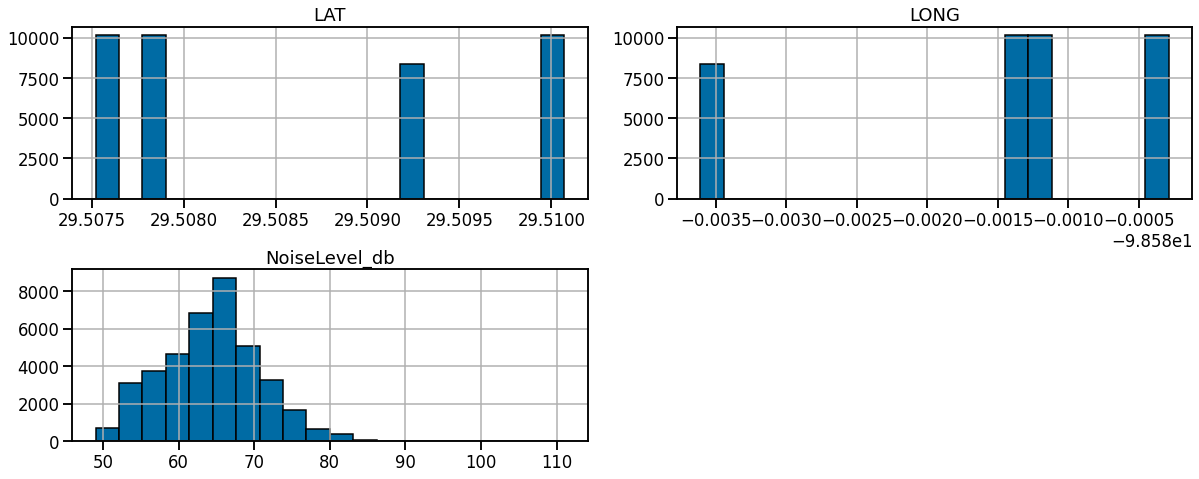

In [23]:
df_medical.hist(figsize=(17, 7), bins=20, ec='black')
plt.tight_layout();

## Prepare

## Explore

### Hypothesis Tests

## Conclusions 